In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

import pymc3 as pm
import theano.tensor as tt
import scipy.stats as stats

from theano import shared
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize


tab10 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', 
         '#8C564B', '#CFECF9', '#7F7F7F', '#BCBD22', '#17BECF']

%matplotlib inline

In [2]:
df = pd.read_csv('full_data.csv')
df.head(n=3)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2/25/20,Afghanistan,NaN,NaN,1,NaN
1,2/26/20,Afghanistan,0.0,NaN,1,NaN
2,2/27/20,Afghanistan,0.0,NaN,1,NaN


In [3]:
df.location.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus',
       'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Chile', 'China', 'Colombia',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       "Cote d'Ivoire", 'Democratic Republic of Congo', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Finland', 'France', 'French Guiana',
       'French Polynesia', 'Gabon', 'Georgia', 'Germany', 'Ghana',
       'Gibraltar', 'Greece', 'Guadeloupe', 'Guernsey', 'Guinea',
       'Guyana', 'Vatican', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'International', 'Iran', 'Iraq', 'Ireland', 'Israel',
       'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          2408 non-null   object 
 1   location      2408 non-null   object 
 2   new_cases     2272 non-null   float64
 3   new_deaths    418 non-null    float64
 4   total_cases   2408 non-null   int64  
 5   total_deaths  455 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 113.0+ KB


In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
df = df.fillna(0)
df.head(n=3)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,0.0,0.0,1,0.0
1,2020-02-26,Afghanistan,0.0,0.0,1,0.0
2,2020-02-27,Afghanistan,0.0,0.0,1,0.0


In [7]:
italy = df[(df.location=='Italy') & (df.total_cases >= 0)].total_cases.to_list()
southkorea = df[(df.location=='South Korea') & (df.total_cases >= 0)].total_cases.to_list()
iran = df[(df.location=='Iran') & (df.total_cases >= 0)].total_cases.to_list()
germany = df[(df.location=='Germany') & (df.total_cases >= 0)].total_cases.to_list()
switzerland = df[(df.location=='Switzerland') & (df.total_cases >= 0)].total_cases.to_list()
usa = df[(df.location=='United States') & (df.total_cases >= 0)].total_cases.to_list()
philippines = df[(df.location=='Philippines') & (df.total_cases >= 0)].total_cases.to_list()
china = df[(df.location=='China') & (df.total_cases >= 0)].total_cases.to_list()

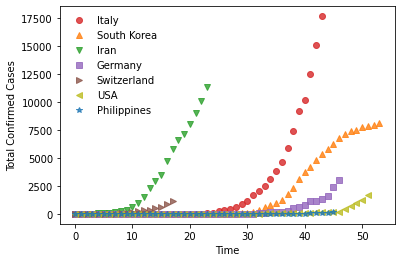

In [8]:
plt.plot(italy, 'o',
         color=tab10[3], alpha = 0.8, label='Italy');
plt.plot(southkorea, '^', 
         color=tab10[1], alpha = 0.8, label='South Korea');
plt.plot(iran, 'v', 
         color=tab10[2], alpha = 0.8, label='Iran');
plt.plot(germany, 's',   
         color=tab10[4], alpha = 0.8, label='Germany');
plt.plot(switzerland, '>', 
         color=tab10[5], alpha = 0.8, label='Switzerland');
plt.plot(usa, '<', 
         color=tab10[8], alpha = 0.8, label='USA');
plt.plot(philippines, '*',
         color=tab10[0], alpha = 0.8, label='Philippines');


plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');

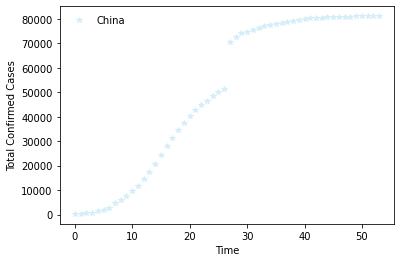

In [9]:
plt.plot(china, '*',
         color=tab10[6], alpha = 0.8, label='China');

plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');

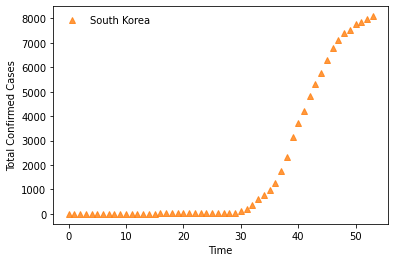

In [10]:
plt.plot(southkorea, '^', 
         color=tab10[1], alpha = 0.8, label='South Korea');

plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');

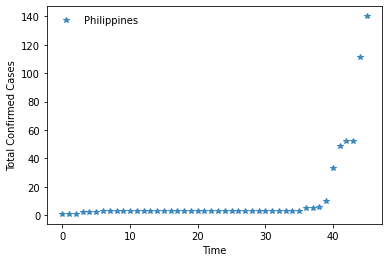

In [11]:
plt.plot(philippines, '*',
         color=tab10[0], alpha = 0.8, label='Philippines');
plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');


In [12]:
##### GP Smoothing
y_southkorea = southkorea[-30:]

Y = np.array(y_southkorea)
X = np.arange(0, len(y_southkorea))

N_SAMPLES = 2000
LARGE_NUMBER = 1e5
with pm.Model() as covid_sokor_model:
    𝛼 = pm.Uniform("a", lower=0,upper=1)
    𝜇 = pm.Normal("mu", sd=100)
    τ = pm.Exponential("tau", 1.0/100)
    infection = GaussianRandomWalk("infection",
                           mu=𝜇,
                           tau=τ / (1.0 - 𝛼),
                           shape=Y.shape)
    covid_observed = pm.Normal("covid_observed",
                    mu=infection,
                    tau=τ / 𝛼,
                    observed=Y)

def infer_infection():
    with covid_sokor_model:
        res = pm.find_MAP(vars=[infection], method="L-BFGS-B")
        return res['infection']
    


In [13]:
covid_sokor_model.check_test_point()

a_interval__     -1.390000e+00
mu               -5.520000e+00
tau_log__        -1.060000e+00
infection         4.486000e+01
covid_observed   -4.414532e+10
Name: Log-probability of test_point, dtype: float64

logp = -2.455e+08, ||grad|| = 4.8368: 100%|██████████| 22/22 [00:00<00:00, 781.58it/s]   


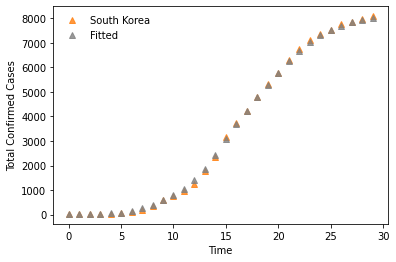

In [14]:
Y_infer_infection = infer_infection()

plt.plot(X, Y, '^', 
         color=tab10[1], alpha = 0.8, label='South Korea');

plt.plot(X, Y_infer_infection, '^', 
         color=tab10[7], alpha = 0.8, label='Fitted' );

plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [infection, tau, mu, a]
Sampling 2 chains, 739 divergences: 100%|██████████| 20400/20400 [00:30<00:00, 664.91draws/s] 
There were 403 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9951403682634589, but should be close to 0.8. Try to increase the number of tuning steps.
There were 335 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9953890453353583, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.156,0.397,-0.553,0.241,0.281,0.238,2.0,2.0,3.0,15.0,1.98
infection[0],-0.436,0.022,-0.459,-0.414,0.016,0.013,2.0,2.0,3.0,37.0,1.96
infection[1],-0.230,0.013,-0.243,-0.218,0.009,0.008,2.0,2.0,3.0,11.0,2.04
infection[2],-0.421,0.009,-0.429,-0.412,0.006,0.005,2.0,2.0,2.0,18.0,2.84
infection[3],0.072,0.011,0.061,0.083,0.008,0.007,2.0,2.0,3.0,11.0,2.08
infection[4],0.134,0.799,-0.665,0.933,0.565,0.479,2.0,2.0,2.0,11.0,2.46
infection[5],0.706,0.031,0.674,0.737,0.022,0.019,2.0,2.0,2.0,12.0,2.45
infection[6],-0.784,0.052,-0.836,-0.732,0.037,0.031,2.0,2.0,2.0,12.0,2.65
infection[7],-0.194,0.590,-0.784,0.395,0.417,0.353,2.0,2.0,3.0,14.0,2.22
infection[8],0.093,0.438,-0.345,0.531,0.310,0.262,2.0,2.0,3.0,12.0,2.06


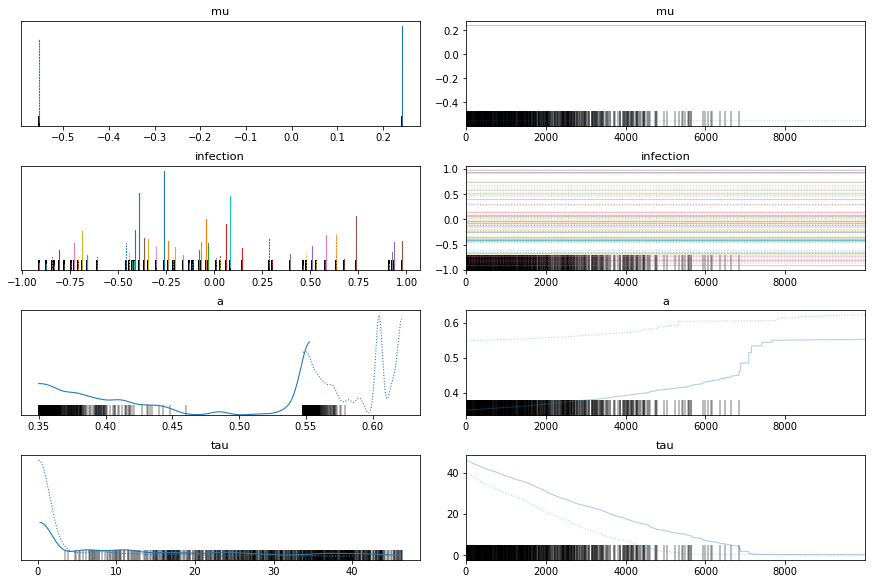

In [15]:
with covid_sokor_model:
    covid_probability_trace = pm.sample(draws=10000, tune=200, cores=2)
pm.traceplot(covid_probability_trace)
pm.summary(covid_probability_trace)